# Customer Churn Prediction – End‑to‑End ML Project 

### 1. PROBLEM STATEMENT

In [1]:
#Goal:

#- Predict whether a customer will churn (leave the service)

#- and enhance prediction using customer complaint text.

#- Business Impact:

#- Identify high‑risk customers early

#- Reduce revenue loss

#- Improve customer retention strategies

### 2. IMPORT LIBRARIES

In [2]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score 
from sklearn.preprocessing import StandardScaler, LabelEncoder 
from sklearn.impute import SimpleImputer 
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

from sklearn.linear_model import LogisticRegression 
from sklearn.ensemble import RandomForestClassifier 
from sklearn.neural_network import MLPClassifier

from sklearn.feature_selection import mutual_info_classif

#Text processing

from sklearn.feature_extraction.text import TfidfVectorizer 
from sklearn.pipeline import Pipeline

#Explainability

import shap

### 3. DATA LOADING (STRUCTURED DATA)

In [3]:
#Dataset: Telco Customer Churn (Kaggle)


df = pd.read_csv('Telco-Customer-Churn.csv')

print(df.head())
print(df.info())

   customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   
3  7795-CFOCW    Male              0      No         No      45           No   
4  9237-HQITU  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity  ... DeviceProtection  \
0  No phone service             DSL             No  ...               No   
1                No             DSL            Yes  ...              Yes   
2                No             DSL            Yes  ...               No   
3  No phone service             DSL            Yes  ...              Yes   
4                No     Fiber optic             No  ...               No   

  TechSupport StreamingTV StreamingMovies        Contract Pape

### 4. DATA UNDERSTANDING

In [4]:
#Target variable: Churn (Yes / No)

#Numerical features: tenure, MonthlyCharges, TotalCharges

#Categorical features: gender, Contract, PaymentMethod, etc.

#Check class imbalance

print(df['Churn'].value_counts())

Churn
No     5174
Yes    1869
Name: count, dtype: int64


### 5. DATA CLEANING & EXPLORATORY DATA ANALYSIS (EDA)

In [5]:
#Basic statistical summary

print(df.describe())

       SeniorCitizen       tenure  MonthlyCharges
count    7043.000000  7043.000000     7043.000000
mean        0.162147    32.371149       64.761692
std         0.368612    24.559481       30.090047
min         0.000000     0.000000       18.250000
25%         0.000000     9.000000       35.500000
50%         0.000000    29.000000       70.350000
75%         0.000000    55.000000       89.850000
max         1.000000    72.000000      118.750000


In [6]:
#Check missing values

print(" Missing values per column: ") 
print(df.isnull().sum())

 Missing values per column: 
customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64


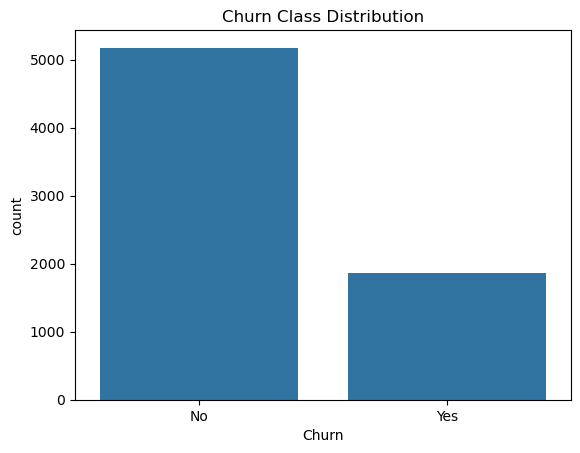

In [8]:
#Visualize target distribution (class imbalance)

plt.figure() 

sns.countplot(x='Churn', data=df) 
plt.title('Churn Class Distribution') 
plt.show()

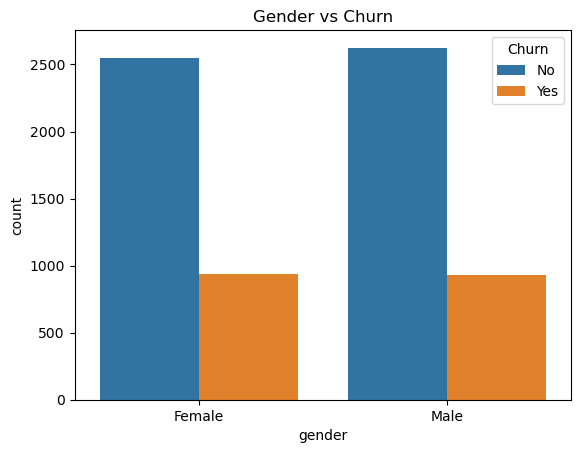

In [9]:
#Gender vs Churn

plt.figure() 
sns.countplot(x='gender', hue='Churn', data=df) 
plt.title('Gender vs Churn') 
plt.show()

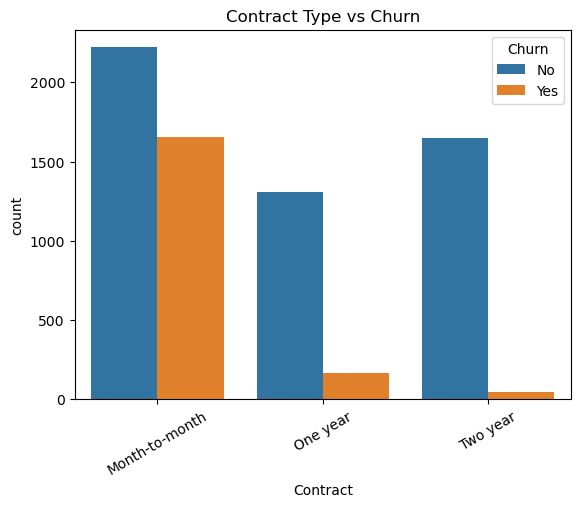

In [10]:
#Contract type vs Churn

plt.figure() 
sns.countplot(x='Contract', hue='Churn', data=df) 
plt.title('Contract Type vs Churn') 
plt.xticks(rotation=30) 
plt.show()

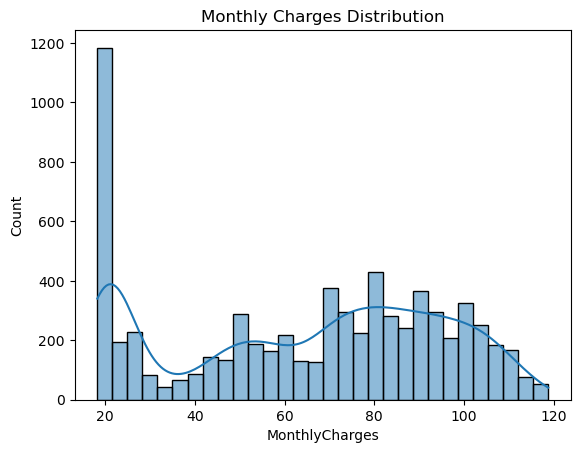

In [11]:
#Monthly Charges Distribution

plt.figure() 
sns.histplot(df['MonthlyCharges'], bins=30, kde=True) 
plt.title('Monthly Charges Distribution') 
plt.show()

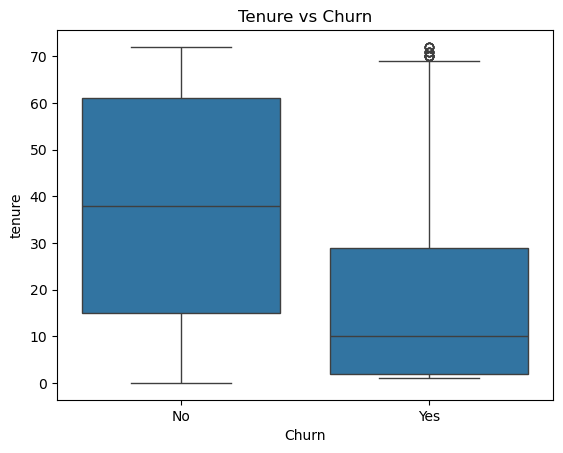

In [12]:
#Tenure vs Churn

plt.figure() 
sns.boxplot(x='Churn', y='tenure', data=df) 
plt.title('Tenure vs Churn') 
plt.show()

#### #Convert TotalCharges to numeric

In [13]:
#Convert TotalCharges to numeric

df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

In [14]:
#Handle missing values

num_cols = ['tenure', 'MonthlyCharges', 'TotalCharges'] 
cat_cols = df.select_dtypes(include='object').columns

num_imputer = SimpleImputer(strategy='median') 
df[num_cols] = num_imputer.fit_transform(df[num_cols])

cat_imputer = SimpleImputer(strategy='most_frequent') 
df[cat_cols] = cat_imputer.fit_transform(df[cat_cols])

In [15]:
df.head(5)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1.0,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34.0,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,3668-QPYBK,Male,0,No,No,2.0,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45.0,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2.0,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


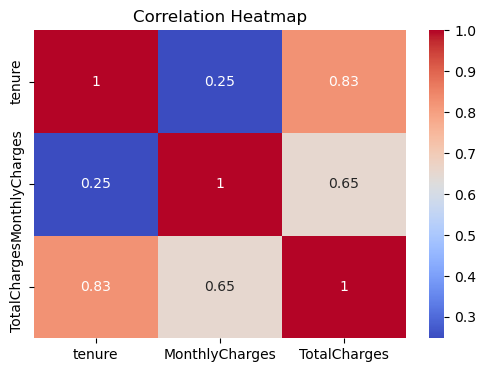

In [16]:
# Correlation heatmap (numerical features)
plt.figure(figsize=(6,4))
sns.heatmap(df[['tenure','MonthlyCharges','TotalCharges']].corr(), annot=True, cmap="coolwarm")
plt.title('Correlation Heatmap')
plt.show()

### 6. OUTLIER HANDLING (IQR METHOD)

In [17]:
Q1 = df['MonthlyCharges'].quantile(0.25) 
Q3 = df['MonthlyCharges'].quantile(0.75) 
IQR = Q3 - Q1

df = df[(df['MonthlyCharges'] >= Q1 - 1.5 * IQR) & 
(df['MonthlyCharges'] <= Q3 + 1.5 * IQR)]

In [18]:
df.describe()

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges
count,7043.000000,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692,2281.916928
std,0.368612,24.559481,30.090047,2265.270398
min,0.000000,0.000000,18.250000,18.800000
25%,0.000000,9.000000,35.500000,402.225000
50%,0.000000,29.000000,70.350000,1397.475000
75%,0.000000,55.000000,89.850000,3786.600000
max,1.000000,72.000000,118.750000,8684.800000


### 7. FEATURE ENGINEERING

In [19]:
#Create new feature: AverageChargesPerMonth

df['AvgCharge'] = df['TotalCharges'] / (df['tenure'] + 1)

In [20]:
df['AvgCharge']

0        14.925000
1        53.985714
2        36.050000
3        40.016304
4        50.550000
           ...    
7038     79.620000
7039    100.861644
7040     28.870833
7041     61.320000
7042    102.156716
Name: AvgCharge, Length: 7043, dtype: float64

In [21]:
#Encode target

le = LabelEncoder() 
df['Churn'] = le.fit_transform(df['Churn'])

In [22]:
#One‑hot encoding for categorical variables

df = pd.get_dummies(df, drop_first=True)

In [23]:
df

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,Churn,AvgCharge,customerID_0003-MKNFE,customerID_0004-TLHLJ,customerID_0011-IGKFF,customerID_0013-EXCHZ,...,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,0,1.0,29.85,29.85,0,14.925000,False,False,False,False,...,False,False,False,False,False,False,True,False,True,False
1,0,34.0,56.95,1889.50,0,53.985714,False,False,False,False,...,False,False,False,False,True,False,False,False,False,True
2,0,2.0,53.85,108.15,1,36.050000,False,False,False,False,...,False,False,False,False,False,False,True,False,False,True
3,0,45.0,42.30,1840.75,0,40.016304,False,False,False,False,...,False,False,False,False,True,False,False,False,False,False
4,0,2.0,70.70,151.65,1,50.550000,False,False,False,False,...,False,False,False,False,False,False,True,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,0,24.0,84.80,1990.50,0,79.620000,False,False,False,False,...,False,True,False,True,True,False,True,False,False,True
7039,0,72.0,103.20,7362.90,0,100.861644,False,False,False,False,...,False,True,False,True,True,False,True,True,False,False
7040,0,11.0,29.60,346.45,0,28.870833,False,False,False,False,...,False,False,False,False,False,False,True,False,True,False
7041,1,4.0,74.40,306.60,1,61.320000,False,False,False,False,...,False,False,False,False,False,False,True,False,False,True


### 8. FEATURE SELECTION

In [24]:
X = df.drop('Churn', axis=1) 
y = df['Churn']

In [25]:
#Correlation analysis

corr = X.corrwith(y).sort_values(ascending=False) 
print(corr.head())

InternetService_Fiber optic       0.308020
PaymentMethod_Electronic check    0.301919
MonthlyCharges                    0.193356
PaperlessBilling_Yes              0.191825
SeniorCitizen                     0.150889
dtype: float64


### 9. TRAIN‑TEST SPLIT

In [26]:
X_train, X_test, y_train, y_test = train_test_split( 
    X, y, test_size=0.2, random_state=42, stratify=y)

scaler = StandardScaler() 
X_train_scaled = scaler.fit_transform(X_train) 
X_test_scaled = scaler.transform(X_test)

### 10. MODEL 1 – BASELINE (LOGISTIC REGRESSION)

In [27]:
log_reg = LogisticRegression(max_iter=1000) 
log_reg.fit(X_train_scaled, y_train)

y_pred_lr = log_reg.predict(X_test_scaled)

print('Logistic Regression Accuracy:', accuracy_score(y_test, y_pred_lr))

Logistic Regression Accuracy: 0.7842441447835344


### 11. MODEL 2 – TREE‑BASED (RANDOM FOREST)

In [28]:
rf = RandomForestClassifier(random_state=42) 
rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test) 
print('Random Forest Accuracy:', accuracy_score(y_test, y_pred_rf))

Random Forest Accuracy: 0.7970191625266146


### 12. MODEL 3 – ADVANCED (NEURAL NETWORK)

In [29]:
nn = MLPClassifier(hidden_layer_sizes=(64,32), max_iter=500, random_state=42) 
nn.fit(X_train_scaled, y_train)

y_pred_nn = nn.predict(X_test_scaled) 
print('Neural Network Accuracy:', accuracy_score(y_test, y_pred_nn))

Neural Network Accuracy: 0.7345635202271115


### 13. HYPERPARAMETER TUNING (RANDOM FOREST)

In [31]:
param_grid = { 'n_estimators': [100, 200], 'max_depth': [None, 10, 20] }

grid = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=3, scoring='f1')

grid.fit(X_train, y_train) 
print('Best Params:', grid.best_params_)

best_rf = grid.best_estimator_

Best Params: {'max_depth': None, 'n_estimators': 200}


### 14. MODEL EVALUATION

Precision: 0.6743295019157088
Recall: 0.47058823529411764
F1 Score: 0.5543307086614173


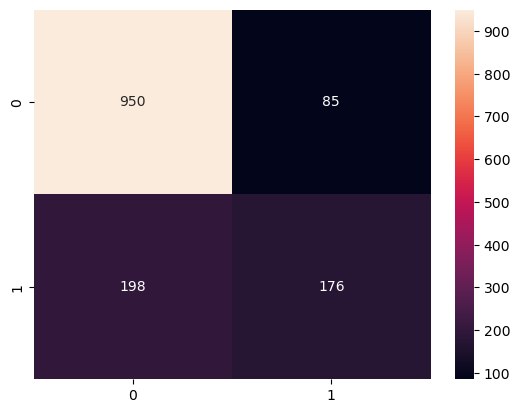

In [32]:
y_pred_best = best_rf.predict(X_test)

print('Precision:', precision_score(y_test, y_pred_best)) 
print('Recall:', recall_score(y_test, y_pred_best)) 
print('F1 Score:', f1_score(y_test, y_pred_best))

cm = confusion_matrix(y_test, y_pred_best) 
sns.heatmap(cm, annot=True, fmt='d') 
plt.show()

### 15. ERROR ANALYSIS (RCA)

In [34]:
#False Positives: Predicted churn but customer stayed

#False Negatives: Missed actual churn customers

# - Observation:

#* Short tenure + month‑to‑month contracts cause false positives

#* Long tenure customers with sudden charge increase cause false negatives

# - Corrective Actions:

#* Add usage trend features

#* Include customer complaint sentiment

### 16. UNSTRUCTURED DATA – TEXT

In [33]:
# Dataset - CONSUMER COMPLAINTS - (Kaggle)

text_df = pd.read_csv('Consumer-Complaints.csv', low_memory=False)

print(text_df.head()) 
print(text_df.info())

  Date received                                            Product  \
0    05/10/2019                        Checking or savings account   
1    05/10/2019                        Checking or savings account   
2    05/10/2019                                    Debt collection   
3    05/10/2019  Credit reporting, credit repair services, or o...   
4    05/10/2019                        Checking or savings account   

                        Sub-product                                 Issue  \
0                  Checking account                   Managing an account   
1  Other banking product or service                   Managing an account   
2                  Payday loan debt                 Communication tactics   
3                  Credit reporting  Incorrect information on your report   
4                  Checking account                   Managing an account   

                                      Sub-issue Consumer complaint narrative  \
0             Problem using a debit 

In [34]:
text_df

,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID
0,05/10/2019,Checking or savings account,Checking account,Managing an account,Problem using a debit or ATM card,NaN,NaN,NAVY FEDERAL CREDIT UNION,FL,328XX,Older American,NaN,Web,05/10/2019,In progress,Yes,NaN,3238275
1,05/10/2019,Checking or savings account,Other banking product or service,Managing an account,Deposits and withdrawals,NaN,NaN,BOEING EMPLOYEES CREDIT UNION,WA,98204,NaN,NaN,Referral,05/10/2019,Closed with explanation,Yes,NaN,3238228
2,05/10/2019,Debt collection,Payday loan debt,Communication tactics,Frequent or repeated calls,NaN,NaN,CURO Intermediate Holdings,TX,751XX,NaN,NaN,Web,05/10/2019,Closed with explanation,Yes,NaN,3237964
3,05/10/2019,"Credit reporting, credit repair services, or o...",Credit reporting,Incorrect information on your report,Old information reappears or never goes away,NaN,NaN,Ad Astra Recovery Services Inc,LA,708XX,NaN,NaN,Web,05/10/2019,Closed with explanation,Yes,NaN,3238479
4,05/10/2019,Checking or savings account,Checking account,Managing an account,Banking errors,NaN,NaN,ALLY FINANCIAL INC.,AZ,85205,NaN,NaN,Postal mail,05/10/2019,In progress,Yes,NaN,3238460
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1282350,12/01/2011,Credit card,NaN,Credit determination,NaN,NaN,NaN,"CITIBANK, N.A.",MO,63301,NaN,NaN,Web,12/02/2011,Closed with relief,Yes,No,2396
1282351,12/01/2011,Mortgage,Conventional fixed mortgage,"Loan modification,collection,foreclosure",NaN,NaN,NaN,"BANK OF AMERICA, NATIONAL ASSOCIATION",OH,45248,NaN,NaN,Web,12/06/2011,Closed without relief,No,No,2323
1282352,12/01/2011,Credit card,NaN,Billing disputes,NaN,NaN,NaN,JPMORGAN CHASE & CO.,OH,43207,NaN,NaN,Referral,12/01/2011,Closed with relief,Yes,No,2126
1282353,12/01/2011,Mortgage,Conventional adjustable mortgage (ARM),"Loan servicing, payments, escrow account",NaN,NaN,NaN,"BANK OF AMERICA, NATIONAL ASSOCIATION",CO,80920,NaN,NaN,Web,12/01/2011,Closed with relief,Yes,No,2315


In [35]:
#Text Cleaning
# Rename for convenience
text_df = text_df.rename(columns={'Consumer complaint narrative': 'complaint_text'})

# Now clean the text
text_df['complaint_text'] = text_df['complaint_text'].str.lower()
text_df['complaint_text'] = text_df['complaint_text'].str.replace('[^a-z ]', '', regex=True)
text_df['complaint_text'] = text_df['complaint_text'].str.strip()

In [36]:
#Remove empty complaints

text_df = text_df[text_df['complaint_text'] != '']

#### TEXT EDA

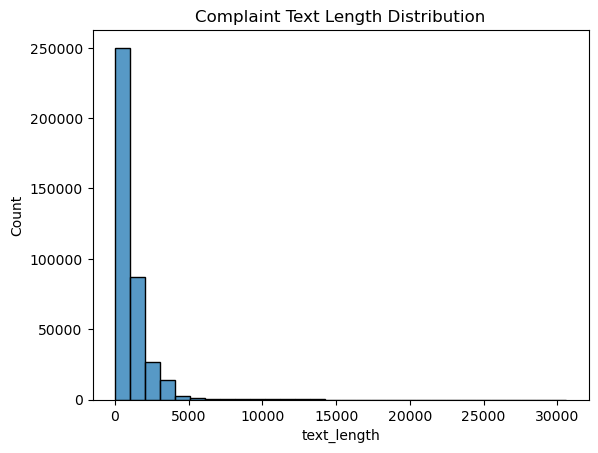

In [37]:
# Length of complaints
text_df['text_length'] = text_df['complaint_text'].str.len()

plt.figure()
sns.histplot(text_df['text_length'].dropna(), bins=30)  
plt.title('Complaint Text Length Distribution')
plt.show()

#### TEXT FEATURE EXTRACTION (TF-IDF)

In [38]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

# 1. Replace NaN with empty string
text_df['complaint_text'] = text_df['complaint_text'].fillna('')

# 2. Drop rows that are empty after cleaning
text_df = text_df[text_df['complaint_text'].str.strip() != '']

# 3. TF-IDF vectorization
tfidf = TfidfVectorizer(stop_words='english', max_features=500)
X_text = tfidf.fit_transform(text_df['complaint_text'])

# 4. Align target labels 
y_text = y.iloc[:X_text.shape[0]]

In [39]:
# Removes rows that contain missing values (NaN)
text_df = text_df.dropna(subset=['complaint_text'])

# TF-IDF vectorization
tfidf = TfidfVectorizer(stop_words='english', max_features=500)
X_text = tfidf.fit_transform(text_df['complaint_text'])

# Use complaint dataset’s own labels, e.g. "Company response to consumer"
y_text = text_df['Company response to consumer'].dropna()

#TEXT MODEL – LOGISTIC REGRESSION
text_model = LogisticRegression(max_iter=1000)
text_model.fit(X_text[:len(y_text)], y_text)

LogisticRegression(max_iter=1000)

In [40]:
#Text-based churn risk prediction

text_churn_prob = text_model.predict_proba(X_text)[:, 1]

print('Text model trained successfully')

Text model trained successfully


### 17. INTEGRATION LOGIC (STRUCTURED + TEXT)

In [41]:
# Final risk score = weighted combination

structured_prob = best_rf.predict_proba(X_test)[:, 1] 
text_prob_sample = text_churn_prob[:len(structured_prob)]

final_risk_score = 0.7 * structured_prob + 0.3 * text_prob_sample

print('Sample Final Risk Scores:', final_risk_score[:5])

#Combine structured churn probability + text sentiment score
#Final risk = 0.7 * churn_model + 0.3 * text_model

Sample Final Risk Scores: [0.24749546 0.72604533 0.29554533 0.41104533 0.26754533]


### 18. MODEL EXPLAINABILITY (SHAP)

In [ ]:
# Create SHAP explainer for tuned RandomForest
explainer = shap.TreeExplainer(best_rf)

# Convert X_test to NumPy if it's a DataFrame
X_test_dense = X_test.to_numpy()

# Use only 200 rows 
X_sample = X_test_dense[:200]

# Compute SHAP values
shap_values = explainer.shap_values(X_sample)

# Plot summary for positive class (index 1 for binary classification)
shap.summary_plot(shap_values[1], X_sample)

### 19. DEPLOYMENT DESIGN (THEORY)

In [ ]:
# Flask / FastAPI API

# Input: Customer JSON + optional complaint text

# Process: Feature engineering → model inference

# Output: Churn probability + explanation


# AWS Flow:

# API Gateway → EC2 / ECS → Model Service → CloudWatch Monitoring

### 20. PERFORMANCE & SCALABILITY

In [ ]:
# Batch processing using Spark for large datasets

# Real‑time predictions via REST API

# Model versioning using MLflow

# Drift monitoring & retraining

### 21. LEARNINGS

In [ ]:
# Feature engineering improves model accuracy significantly

# Error analysis reveals real business insights

# Text data enhances churn understanding

# Deployment thinking is critical for real‑world ML